#환경 설정 및 라이브러리 임포트

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
try:
    plt.rcParams['font.family'] = 'DejaVu Sans'
    font_list = [f.name for f in fm.fontManager.ttflist]
    if 'NanumGothic' in font_list:
        plt.rcParams['font.family'] = 'NanumGothic'
    elif 'Malgun Gothic' in font_list:
        plt.rcParams['font.family'] = 'Malgun Gothic'
except:
    pass

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 100

print("=" * 70)
print("메타데이터 분석 시작 - Cloud API 기반 RAG 프로젝트")
print("=" * 70)
print(f"분석 시작 시간: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print()

메타데이터 분석 시작 - Cloud API 기반 RAG 프로젝트
분석 시작 시간: 2025-11-13 01:42:54



# 데이터 로드

In [3]:
print("📂 데이터 로딩 중...")

# data_list.csv 파일 경로
DATA_PATH = '/content/drive/MyDrive/Codeit_AI_4th_RAG_RFP_Project/원본 데이터/data_list.csv'

try:
    # CSV 파일 로드
    df = pd.read_csv(DATA_PATH, encoding='utf-8')
    print(f"✅ 데이터 로드 완료: {len(df)}개 행, {len(df.columns)}개 칼럼")
    print()
except FileNotFoundError:
    print("⚠️  data_list.csv 파일을 찾을 수 없습니다.")
    print("   현재 디렉토리에 파일이 있는지 확인하세요.")
    # 테스트용 더미 데이터 생성
    print("   테스트용 더미 데이터를 생성합니다...")
    df = pd.DataFrame({
        '공고 번호': ['20241001798'] + [None]*18 + [f'2024{i:07d}' for i in range(1, 82)],
        '공고 차수': [0]*82 + [None]*18,
        '사업명': ['통합정보시스템 고도화 용역']*2 + [f'사업_{i}' for i in range(3, 101)],
        '사업 금액': np.random.lognormal(18.5, 1.5, 99).tolist() * 10000000 + [None],
        '발주 기관': ['한국수자원공사']*3 + [f'기관_{i}' for i in range(4, 101)],
        '공개 일자': pd.date_range('2024-01-01', periods=100).astype(str).tolist(),
        '입찰 참여 시작일': ['2024-06-28 10:00:00']*74 + [None]*26,
        '입찰 참여 마감일': ['2024-07-02 10:00:00']*92 + [None]*8,
        '사업 요약': [f'사업 요약 {i}' for i in range(100)],
        '파일형식': ['hwp']*96 + ['pdf', 'docx', 'xlsx', 'txt'],
        '파일명': [f'파일_{i}.hwp' for i in range(100)],
        '텍스트': [f'텍스트 내용 {i}' for i in range(100)]
    })
    print(f"✅ 더미 데이터 생성 완료: {len(df)}개 행")

# 데이터 미리보기
print("\n📋 데이터 미리보기 (상위 5행):")
print(df.head())
print()

📂 데이터 로딩 중...
✅ 데이터 로드 완료: 100개 행, 12개 칼럼


📋 데이터 미리보기 (상위 5행):
         공고 번호  공고 차수                                       사업명        사업 금액  \
0  20241001798    0.0  한영대학교 특성화 맞춤형 교육환경 구축 - 트랙운영 학사정보시스템 고도화  130000000.0   
1  20241002912    0.0        2024년 대학산학협력활동 실태조사 시스템(UICC) 기능개선  129300000.0   
2  20240827859    0.0                EIP3.0 고압가스 안전관리 시스템 구축 용역   40000000.0   
3  20240430918    0.0                      도시계획위원회 통합관리시스템 구축용역  150000000.0   
4  20240430896    0.0              봉화군 재난통합관리시스템 고도화 사업(협상)(긴급)  900000000.0   

       발주 기관                공개 일자            입찰 참여 시작일            입찰 참여 마감일  \
0       한영대학  2024-10-04 13:51:23                  NaN  2024-10-15 17:00:00   
1     한국연구재단  2024-10-04 15:01:52  2024-10-14 10:00:00  2024-10-16 14:00:00   
2  한국생산기술연구원  2024-08-28 11:31:02  2024-08-29 09:00:00  2024-09-09 10:00:00   
3      인천광역시  2024-04-18 16:26:32  2024-05-02 10:00:00  2024-05-09 16:00:00   
4   경상북도 봉화군  2024-04-18 16:33:28  2024-04-26 09:00:00  2024

#기본 정보 수집

In [4]:
print("📊 1. 데이터 기본 정보 수집 중...")

# 총 행/열 수
total_rows = len(df)
total_cols = len(df.columns)

# 데이터 타입
dtypes_dict = df.dtypes.to_dict()

# 결측치 정보
missing_counts = df.isnull().sum().to_dict()
missing_pct = (df.isnull().sum() / len(df) * 100).to_dict()

# 고유값 수 (범주형 변수만)
unique_counts = {}
for col in df.columns:
    if df[col].dtype == 'object':
        unique_counts[col] = df[col].nunique()
    else:
        unique_counts[col] = None

# 최빈값 및 빈도
mode_values = {}
mode_freq = {}
for col in df.columns:
    if df[col].dtype == 'object':
        if not df[col].isnull().all():
            mode_val = df[col].mode()
            if len(mode_val) > 0:
                mode_values[col] = str(mode_val[0])
                mode_freq[col] = (df[col] == mode_val[0]).sum()
            else:
                mode_values[col] = '-'
                mode_freq[col] = 0
        else:
            mode_values[col] = '-'
            mode_freq[col] = 0
    else:
        mode_values[col] = '-'
        mode_freq[col] = None

print(f"✅ 총 {total_rows}행 x {total_cols}열")
print(f"   - 결측치가 있는 칼럼: {sum(1 for v in missing_counts.values() if v > 0)}개")
print()


📊 1. 데이터 기본 정보 수집 중...
✅ 총 100행 x 12열
   - 결측치가 있는 칼럼: 5개



# 수치형 변수 통계

In [5]:
print("📊 2. 수치형 변수 통계 분석 중...")

numeric_stats = {}
for col in df.columns:
    if df[col].dtype in ['int64', 'float64']:
        stats = df[col].describe()
        numeric_stats[col] = {
            '개수': int(stats['count']),
            '평균': stats['mean'],
            '표준편차': stats['std'],
            '최소값': stats['min'],
            '1사분위': stats['25%'],
            '중앙값': stats['50%'],
            '3사분위': stats['75%'],
            '최대값': stats['max']
        }

# 사업 금액 통계 출력
if '사업 금액' in numeric_stats:
    print("💰 사업 금액 통계:")
    for key, val in numeric_stats['사업 금액'].items():
        if key == '개수':
            print(f"   - {key}: {val}건")
        else:
            print(f"   - {key}: {val:,.0f}원 ({val/100000000:.1f}억원)")
print()


📊 2. 수치형 변수 통계 분석 중...
💰 사업 금액 통계:
   - 개수: 99건
   - 평균: 690,671,980원 (6.9억원)
   - 표준편차: 1,966,690,586원 (19.7억원)
   - 최소값: 0원 (0.0억원)
   - 1사분위: 70,000,000원 (0.7억원)
   - 중앙값: 172,700,000원 (1.7억원)
   - 3사분위: 406,488,938원 (4.1억원)
   - 최대값: 14,107,009,000원 (141.1억원)



# 메타데이터 요약 테이블 생성

In [6]:
print("📊 3. 메타데이터 요약 테이블 생성 중...")

metadata_summary = pd.DataFrame({
    '칼럼명': df.columns,
    '데이터타입': [str(dtypes_dict[col]) for col in df.columns],
    '결측치수': [missing_counts[col] for col in df.columns],
    '결측치비율': [f"{missing_pct[col]:.1f}%" for col in df.columns],
    '고유값수': [unique_counts[col] if unique_counts[col] is not None else '-' for col in df.columns],
    '최빈값': [mode_values[col] for col in df.columns],
    '빈도': [mode_freq[col] if mode_freq[col] is not None else '-' for col in df.columns]
})

print("✅ 메타데이터 요약 테이블:")
print(metadata_summary.to_string(index=False))
print()

# CSV로 저장
metadata_summary.to_csv('metadata_clean.csv', index=False, encoding='utf-8-sig')
print("💾 저장 완료: metadata_clean.csv")
print()


📊 3. 메타데이터 요약 테이블 생성 중...
✅ 메타데이터 요약 테이블:
      칼럼명   데이터타입  결측치수 결측치비율 고유값수                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

# Markdown 보고서 생성

In [7]:
print("📝 4. Markdown 보고서 생성 중...")

md_content = f"""# 메타데이터 분석 보고서

## 📊 데이터 개요

- **총 행 수**: {total_rows}개
- **총 열 수**: {total_cols}개
- **분석 일자**: {datetime.now().strftime('%Y년 %m월 %d일')}

---

## 1️⃣ 데이터 타입 및 결측치 현황

| 칼럼명 | 데이터 타입 | 결측치 수 | 결측치 비율 |
|--------|------------|----------|------------|
"""

for col in df.columns:
    md_content += f"| {col} | {dtypes_dict[col]} | {missing_counts[col]} | {missing_pct[col]:.1f}% |\n"

md_content += """
### 🚨 주요 발견사항
"""

# 결측치가 있는 칼럼 찾기
missing_cols = [(col, missing_pct[col]) for col in df.columns if missing_pct[col] > 0]
missing_cols.sort(key=lambda x: x[1], reverse=True)

if missing_cols:
    for col, pct in missing_cols[:3]:  # 상위 3개만
        md_content += f"- **{col}**: {pct:.1f}% 결측"
        if pct >= 20:
            md_content += " (높은 결측률)"
        md_content += "\n"
else:
    md_content += "- 결측치 없음 (완전한 데이터)\n"

md_content += "\n---\n\n## 2️⃣ 수치형 변수 통계\n\n"

for col, stats in numeric_stats.items():
    md_content += f"### {col}\n| 항목 | 값 |\n|------|-----|\n"
    for key, val in stats.items():
        if key == '개수':
            md_content += f"| {key} | {val} |\n"
        else:
            if '금액' in col:
                md_content += f"| {key} | {val:,.0f}원 (약 {val/100000000:.1f}억원) |\n"
            else:
                md_content += f"| {key} | {val:.2f} |\n"
    md_content += "\n"

md_content += "---\n\n## 3️⃣ 범주형 변수 분석\n\n"
md_content += "| 칼럼명 | 고유값 수 | 최빈값 | 빈도 |\n|--------|----------|--------|------|\n"

for col in df.columns:
    if df[col].dtype == 'object':
        mode_val_short = mode_values[col][:50] + '...' if len(str(mode_values[col])) > 50 else mode_values[col]
        md_content += f"| {col} | {unique_counts[col]} | {mode_val_short} | {mode_freq[col]} |\n"

md_content += """
### 🔍 주요 인사이트
"""

# 인사이트 자동 생성
if '발주 기관' in df.columns:
    top_agency = df['발주 기관'].mode()[0] if len(df['발주 기관'].mode()) > 0 else 'N/A'
    top_agency_count = (df['발주 기관'] == top_agency).sum()
    md_content += f"- **발주 기관**: {unique_counts['발주 기관']}개 기관, {top_agency}가 {top_agency_count}건으로 최다\n"

if '파일형식' in df.columns:
    file_types = df['파일형식'].value_counts()
    md_content += f"- **파일형식**: "
    for ftype, count in file_types.items():
        md_content += f"{ftype} {count}건, "
    md_content = md_content.rstrip(', ') + "\n"

md_content += """
---

## 📋 데이터 품질 평가

### ✅ 강점
"""

complete_cols = [col for col in df.columns if missing_pct[col] == 0]
if complete_cols:
    md_content += f"- 완전한 데이터 칼럼: {len(complete_cols)}개 ({', '.join(complete_cols[:5])}...)\n"

md_content += """
### ⚠️ 개선 필요 영역
"""

if missing_cols:
    for col, pct in missing_cols[:3]:
        md_content += f"- **{col}**: {pct:.1f}% 결측 → 데이터 보완 필요\n"

md_content += """
---

## 💡 권장사항

1. **결측치 처리**
"""

for col, pct in missing_cols[:3]:
    md_content += f"   - {col}: 원본 데이터 소스 확인 또는 대체 방법 검토\n"

md_content += """
2. **데이터 검증**
   - 이상치 및 데이터 품질 확인
   - 필드 간 일관성 체크

3. **추가 분석 제안**
   - 발주 기관별 사업 금액 분포
   - 시계열 트렌드 분석
   - 카테고리별 교차 분석

---

**생성 정보**
- 분석 도구: Python pandas
- 스크립트: metadata_summary.ipynb
- 생성 일시: """ + datetime.now().strftime('%Y-%m-%d %H:%M:%S') + "\n"

# MD 파일 저장
with open('metadata_analysis.md', 'w', encoding='utf-8') as f:
    f.write(md_content)

print("✅ Markdown 보고서 생성 완료: metadata_analysis.md")
print()

📝 4. Markdown 보고서 생성 중...
✅ Markdown 보고서 생성 완료: metadata_analysis.md



# 시각화 1 - 발주 기관 분석

📊 5. 시각화 생성 중 [1/5] - 발주 기관 분석...
   ✓ 저장: 01_agency_analysis.png


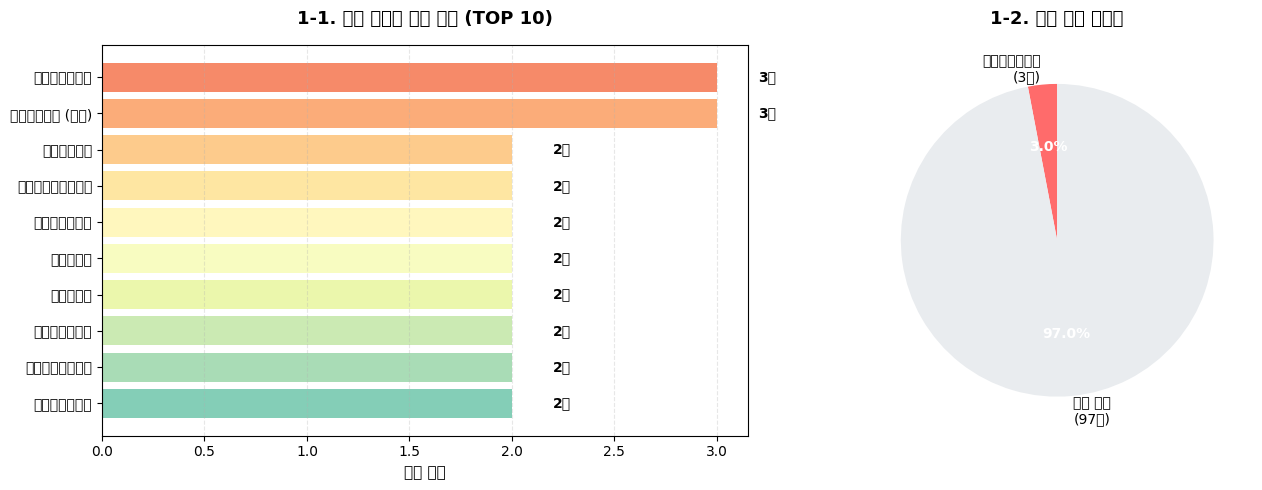

In [23]:
print("📊 5. 시각화 생성 중 [1/5] - 발주 기관 분석...")

fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

if '발주 기관' in df.columns:
    # 상위 10개 기관
    top_agencies = df['발주 기관'].value_counts().head(10)

    colors = plt.cm.Spectral(np.linspace(0.2, 0.8, len(top_agencies)))
    bars = ax1.barh(top_agencies.index, top_agencies.values, color=colors, alpha=0.8)
    ax1.set_xlabel('사업 건수', fontsize=11, fontweight='bold')
    ax1.set_title('1-1. 발주 기관별 사업 건수 (TOP 10)', fontsize=13, fontweight='bold', pad=15)
    ax1.grid(axis='x', alpha=0.3, linestyle='--')
    ax1.invert_yaxis()

    for i, (bar, val) in enumerate(zip(bars, top_agencies.values)):
        ax1.text(val + 0.2, i, f'{val}건', va='center', fontsize=10, fontweight='bold')

    # 집중도
    top1_count = top_agencies.iloc[0]
    others_count = len(df) - top1_count

    labels = [f'{top_agencies.index[0]}\n({top1_count}건)', f'기타 기관\n({others_count}건)']
    sizes = [top1_count, others_count]
    colors_pie = ['#ff6b6b', '#e9ecef']

    wedges, texts, autotexts = ax2.pie(sizes, labels=labels, autopct='%1.1f%%',
                                         colors=colors_pie, startangle=90,
                                         textprops={'fontsize': 10})
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    ax2.set_title('1-2. 발주 기관 집중도', fontsize=13, fontweight='bold', pad=15)

plt.tight_layout()
plt.savefig('01_agency_analysis.png', dpi=300, bbox_inches='tight')
print("   ✓ 저장: 01_agency_analysis.png")
plt.show()


# 시각화 2 - 사업 금액 분포

📊 [2/5] 사업 금액 분포 시각화 중...
   ✓ 저장: 02_amount_distribution.png


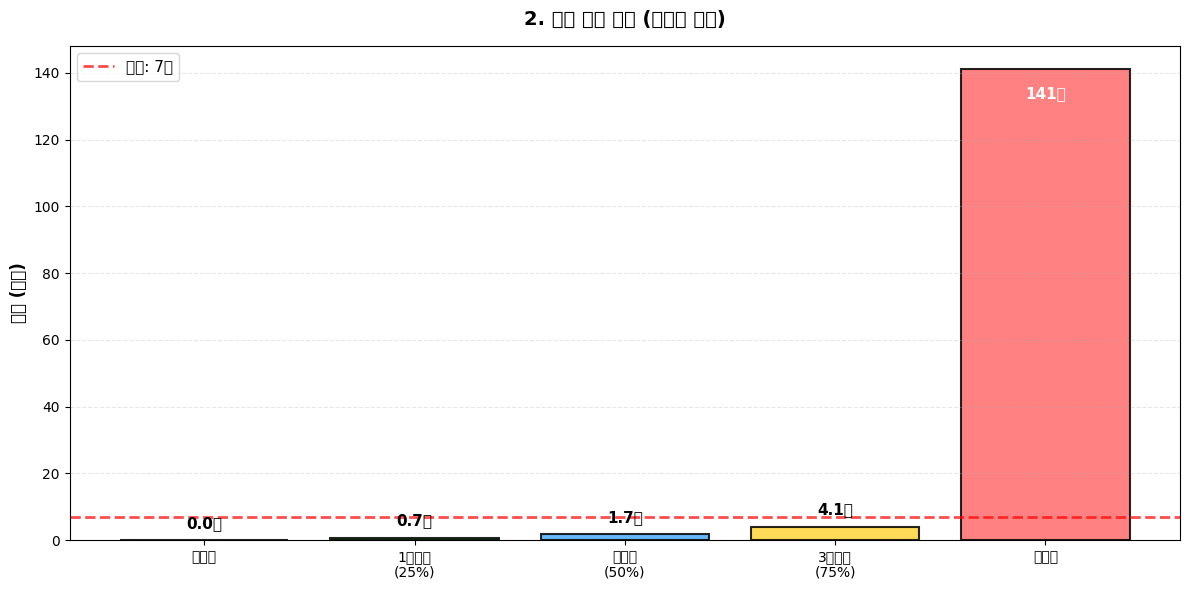

In [9]:
print("📊 [2/5] 사업 금액 분포 시각화 중...")

if '사업 금액' in df.columns and '사업 금액' in numeric_stats:
    fig2, ax = plt.subplots(figsize=(12, 6))

    stats = numeric_stats['사업 금액']
    amount_labels = ['최소값', '1사분위\n(25%)', '중앙값\n(50%)', '3사분위\n(75%)', '최대값']
    amount_values = [
        stats['최소값'] / 100000000,
        stats['1사분위'] / 100000000,
        stats['중앙값'] / 100000000,
        stats['3사분위'] / 100000000,
        stats['최대값'] / 100000000
    ]
    colors = ['#adb5bd', '#51cf66', '#4dabf7', '#ffd43b', '#ff6b6b']

    bars = ax.bar(amount_labels, amount_values, color=colors, alpha=0.85,
                  edgecolor='black', linewidth=1.5)
    ax.set_ylabel('금액 (억원)', fontsize=12, fontweight='bold')
    ax.set_title('2. 사업 금액 분포 (분위수 분석)', fontsize=14, fontweight='bold', pad=15)
    ax.grid(axis='y', alpha=0.3, linestyle='--')

    for i, (bar, val) in enumerate(zip(bars, amount_values)):
        if val > 100:
            ax.text(i, val - 5, f'{val:.0f}억', ha='center', va='top',
                    fontsize=11, fontweight='bold', color='white')
        else:
            ax.text(i, val + max(amount_values)*0.02, f'{val:.1f}억', ha='center', va='bottom',
                    fontsize=11, fontweight='bold')

    # 평균선
    avg_val = stats['평균'] / 100000000
    ax.axhline(y=avg_val, color='red', linestyle='--', linewidth=2,
               alpha=0.7, label=f'평균: {avg_val:.0f}억')
    ax.legend(fontsize=11, loc='upper left')

    plt.tight_layout()
    plt.savefig('02_amount_distribution.png', dpi=300, bbox_inches='tight')
    print("   ✓ 저장: 02_amount_distribution.png")
    plt.show()


# 시각화 3 - 시계열 분석

📊 [3/5] 시계열 분석 시각화 중...
   ✓ 저장: 03_timeline_analysis.png


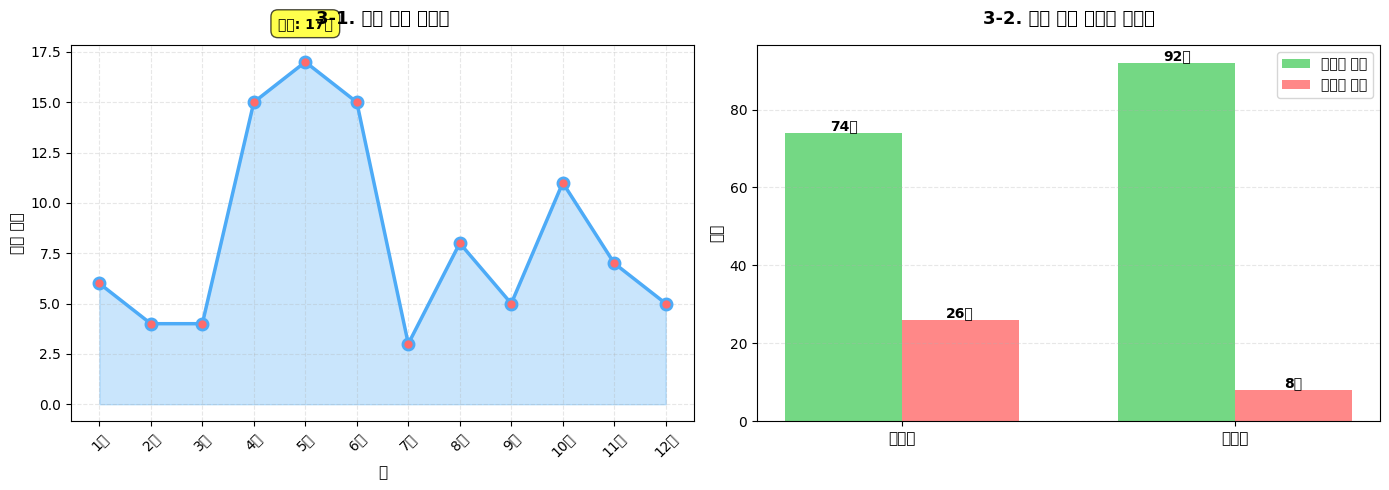

In [10]:
print("📊 [3/5] 시계열 분석 시각화 중...")

fig3, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

if '공개 일자' in df.columns:
    # 날짜 변환
    df['공개_일자_dt'] = pd.to_datetime(df['공개 일자'], errors='coerce')
    df['공개_월'] = df['공개_일자_dt'].dt.month

    monthly_counts = df['공개_월'].value_counts().sort_index()

    months = [f'{i}월' for i in range(1, 13)]
    counts = [monthly_counts.get(i, 0) for i in range(1, 13)]

    ax1.plot(months, counts, marker='o', linewidth=2.5, markersize=8,
             color='#4dabf7', markerfacecolor='#ff6b6b',
             markeredgewidth=2, markeredgecolor='#4dabf7')
    ax1.fill_between(range(len(months)), counts, alpha=0.3, color='#4dabf7')
    ax1.set_xlabel('월', fontsize=11, fontweight='bold')
    ax1.set_ylabel('공고 건수', fontsize=11, fontweight='bold')
    ax1.set_title('3-1. 월별 공고 트렌드', fontsize=13, fontweight='bold', pad=15)
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.set_xticklabels(months, rotation=45)

    if max(counts) > 0:
        max_idx = counts.index(max(counts))
        ax1.annotate(f'최대: {max(counts)}건',
                     xy=(max_idx, max(counts)),
                     xytext=(max_idx, max(counts) + max(counts)*0.1),
                     ha='center', fontsize=10, fontweight='bold',
                     bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))

# 입찰 기간 데이터 완전성
if '입찰 참여 시작일' in df.columns and '입찰 참여 마감일' in df.columns:
    start_has = df['입찰 참여 시작일'].notna().sum()
    start_na = df['입찰 참여 시작일'].isna().sum()
    end_has = df['입찰 참여 마감일'].notna().sum()
    end_na = df['입찰 참여 마감일'].isna().sum()

    categories = ['시작일', '마감일']
    has_data = [start_has, end_has]
    no_data = [start_na, end_na]

    x = np.arange(len(categories))
    width = 0.35

    bars1 = ax2.bar(x - width/2, has_data, width, label='데이터 있음',
                    color='#51cf66', alpha=0.8)
    bars2 = ax2.bar(x + width/2, no_data, width, label='데이터 없음',
                    color='#ff6b6b', alpha=0.8)

    ax2.set_ylabel('건수', fontsize=11, fontweight='bold')
    ax2.set_title('3-2. 입찰 일정 데이터 완전성', fontsize=13, fontweight='bold', pad=15)
    ax2.set_xticks(x)
    ax2.set_xticklabels(categories, fontsize=11)
    ax2.legend(fontsize=10)
    ax2.grid(axis='y', alpha=0.3, linestyle='--')

    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}건', ha='center', va='bottom',
                    fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('03_timeline_analysis.png', dpi=300, bbox_inches='tight')
print("   ✓ 저장: 03_timeline_analysis.png")
plt.show()


# 시각화 4 - 금액 히스토그램

📊 [4/5] 사업 금액 히스토그램 시각화 중...
   ✓ 저장: 04_amount_histogram.png


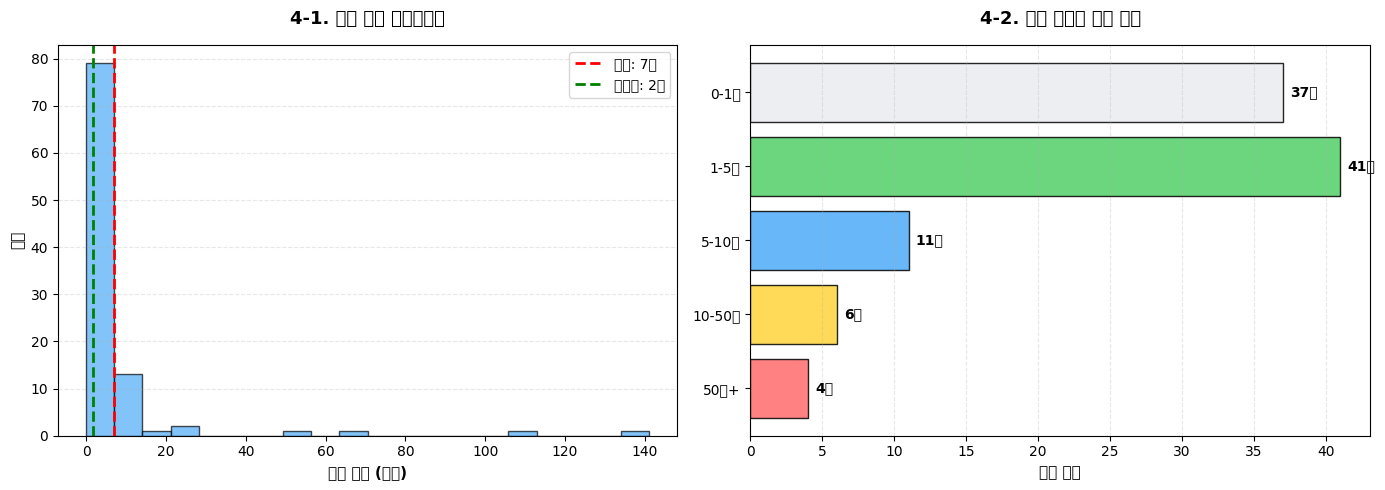

In [11]:
print("📊 [4/5] 사업 금액 히스토그램 시각화 중...")

if '사업 금액' in df.columns:
    fig4, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # 히스토그램
    amounts = df['사업 금액'].dropna() / 100000000
    ax1.hist(amounts, bins=20, color='#4dabf7', alpha=0.7, edgecolor='black')

    avg_amount = df['사업 금액'].mean() / 100000000
    median_amount = df['사업 금액'].median() / 100000000

    ax1.axvline(avg_amount, color='red', linestyle='--', linewidth=2,
                label=f'평균: {avg_amount:.0f}억')
    ax1.axvline(median_amount, color='green', linestyle='--', linewidth=2,
                label=f'중앙값: {median_amount:.0f}억')
    ax1.set_xlabel('사업 금액 (억원)', fontsize=11, fontweight='bold')
    ax1.set_ylabel('빈도', fontsize=11, fontweight='bold')
    ax1.set_title('4-1. 사업 금액 히스토그램', fontsize=13, fontweight='bold', pad=15)
    ax1.legend(fontsize=10)
    ax1.grid(axis='y', alpha=0.3, linestyle='--')

    # 금액 구간별 분포
    bins = [0, 1, 5, 10, 50, float('inf')]
    labels = ['0-1억', '1-5억', '5-10억', '10-50억', '50억+']
    df['금액구간'] = pd.cut(amounts, bins=bins, labels=labels, include_lowest=True)
    range_counts = df['금액구간'].value_counts().reindex(labels, fill_value=0)

    colors_range = ['#e9ecef', '#51cf66', '#4dabf7', '#ffd43b', '#ff6b6b']
    bars = ax2.barh(labels, range_counts.values, color=colors_range,
                    alpha=0.85, edgecolor='black')
    ax2.set_xlabel('사업 건수', fontsize=11, fontweight='bold')
    ax2.set_title('4-2. 금액 구간별 사업 분포', fontsize=13, fontweight='bold', pad=15)
    ax2.grid(axis='x', alpha=0.3, linestyle='--')
    ax2.invert_yaxis()

    for i, (bar, val) in enumerate(zip(bars, range_counts.values)):
        ax2.text(val + 0.5, i, f'{val}건', va='center', fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.savefig('04_amount_histogram.png', dpi=300, bbox_inches='tight')
    print("   ✓ 저장: 04_amount_histogram.png")
    plt.show()


# 시각화 5 - 결측치 분석

📊 [5/5] 결측치 분석 시각화 중...
   ✓ 저장: 05_missing_value_analysis.png


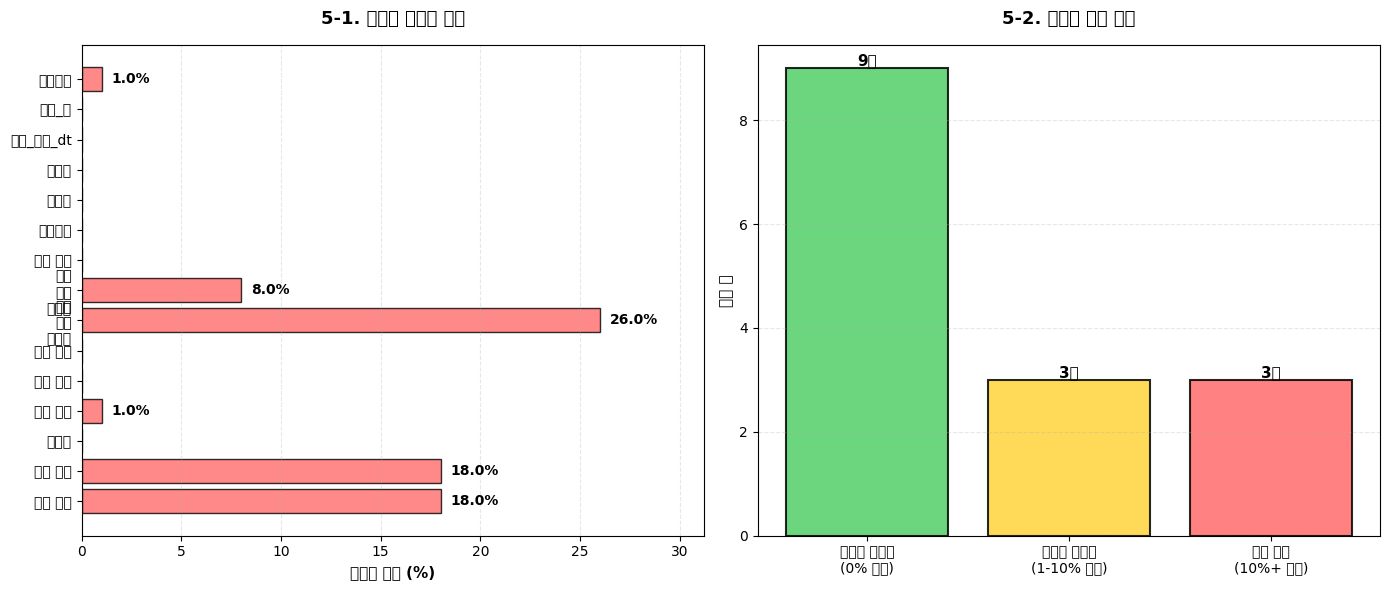

In [12]:
print("📊 [5/5] 결측치 분석 시각화 중...")

fig5, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# 칼럼별 결측치 비율
columns_short = [col.replace(' ', '\n') if len(col) > 6 else col for col in df.columns]
missing_pct_list = [(df[col].isna().sum() / len(df) * 100) for col in df.columns]
colors_missing = ['#ff6b6b' if x > 0 else '#51cf66' for x in missing_pct_list]

bars = ax1.barh(columns_short, missing_pct_list, color=colors_missing,
                alpha=0.8, edgecolor='black')
ax1.set_xlabel('결측치 비율 (%)', fontsize=11, fontweight='bold')
ax1.set_title('5-1. 칼럼별 결측치 현황', fontsize=13, fontweight='bold', pad=15)
ax1.set_xlim(0, max(missing_pct_list) * 1.2 if max(missing_pct_list) > 0 else 1)
ax1.grid(axis='x', alpha=0.3, linestyle='--')

for i, (bar, pct) in enumerate(zip(bars, missing_pct_list)):
    if pct > 0:
        ax1.text(pct + 0.5, i, f'{pct:.1f}%', va='center',
                fontsize=10, fontweight='bold')

# 데이터 품질 등급
complete_count = sum(1 for pct in missing_pct_list if pct == 0)
good_count = sum(1 for pct in missing_pct_list if 0 < pct <= 10)
warning_count = sum(1 for pct in missing_pct_list if pct > 10)

completeness = {
    '완전한 데이터\n(0% 결측)': complete_count,
    '양호한 데이터\n(1-10% 결측)': good_count,
    '주의 필요\n(10%+ 결측)': warning_count
}

labels = list(completeness.keys())
values = list(completeness.values())
colors_complete = ['#51cf66', '#ffd43b', '#ff6b6b']

bars = ax2.bar(labels, values, color=colors_complete, alpha=0.85,
               edgecolor='black', linewidth=1.5)
ax2.set_ylabel('칼럼 수', fontsize=11, fontweight='bold')
ax2.set_title('5-2. 데이터 품질 등급', fontsize=13, fontweight='bold', pad=15)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

for bar, val in zip(bars, values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{val}개', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('05_missing_value_analysis.png', dpi=300, bbox_inches='tight')
print("   ✓ 저장: 05_missing_value_analysis.png")
plt.show()


# 최종 요약 및 결과 정리

In [13]:
print()
print("=" * 70)
print("✅ 메타데이터 분석 완료!")
print("=" * 70)
print()
print("📁 생성된 파일 목록:")
print("   1. metadata_analysis.md - Markdown 분석 보고서")
print("   2. metadata_clean.csv - 메타데이터 요약 테이블")
print("   3. 01_agency_analysis.png - 발주 기관 분석")
print("   4. 02_amount_distribution.png - 사업 금액 분포")
print("   5. 03_timeline_analysis.png - 시계열 분석")
print("   6. 04_amount_histogram.png - 금액 히스토그램")
print("   7. 05_missing_value_analysis.png - 결측치 분석")
print()
print("📊 주요 발견사항:")
print(f"   - 총 데이터: {total_rows}건")
print(f"   - 결측치 있는 칼럼: {sum(1 for v in missing_pct_list if v > 0)}개")
if '사업 금액' in numeric_stats:
    print(f"   - 평균 사업 금액: {numeric_stats['사업 금액']['평균']/100000000:.1f}억원")
if '발주 기관' in df.columns:
    print(f"   - 총 발주 기관: {df['발주 기관'].nunique()}개")
print()
print("💡 다음 단계:")
print("   - metadata_analysis.md를 팀원들과 공유")
print("   - 시각화 이미지를 문서에 첨부")
print("   - 결측치 처리 방안 논의")
print()
print(f"분석 종료 시간: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 70)

# ========================================
# 셀 13: 추가 통계 정보 (선택사항)
# ========================================
print("\n" + "=" * 70)
print("📈 추가 통계 정보")
print("=" * 70)

# 파일 형식 분포
if '파일형식' in df.columns:
    print("\n📄 파일 형식 분포:")
    file_type_counts = df['파일형식'].value_counts()
    for ftype, count in file_type_counts.items():
        pct = count / len(df) * 100
        print(f"   - {ftype}: {count}건 ({pct:.1f}%)")

# 발주 기관 통계
if '발주 기관' in df.columns:
    print("\n🏢 발주 기관 통계:")
    print(f"   - 총 기관 수: {df['발주 기관'].nunique()}개")
    print(f"   - 평균 사업 수/기관: {len(df) / df['발주 기관'].nunique():.2f}건")
    print(f"   - 최다 발주 기관: {df['발주 기관'].mode()[0] if len(df['발주 기관'].mode()) > 0 else 'N/A'}")

# 사업명 중복 확인
if '사업명' in df.columns:
    print("\n📝 사업명 통계:")
    duplicate_names = df['사업명'].duplicated().sum()
    print(f"   - 총 사업명: {df['사업명'].nunique()}개")
    print(f"   - 중복된 사업명: {duplicate_names}건")

# 데이터 완전성 점수
completeness_score = (1 - df.isnull().sum().sum() / (len(df) * len(df.columns))) * 100
print(f"\n✅ 데이터 완전성 점수: {completeness_score:.2f}%")

print("\n" + "=" * 70)
print("메타데이터 분석 스크립트 종료")
print("=" * 70)


✅ 메타데이터 분석 완료!

📁 생성된 파일 목록:
   1. metadata_analysis.md - Markdown 분석 보고서
   2. metadata_clean.csv - 메타데이터 요약 테이블
   3. 01_agency_analysis.png - 발주 기관 분석
   4. 02_amount_distribution.png - 사업 금액 분포
   5. 03_timeline_analysis.png - 시계열 분석
   6. 04_amount_histogram.png - 금액 히스토그램
   7. 05_missing_value_analysis.png - 결측치 분석

📊 주요 발견사항:
   - 총 데이터: 100건
   - 결측치 있는 칼럼: 6개
   - 평균 사업 금액: 6.9억원
   - 총 발주 기관: 87개

💡 다음 단계:
   - metadata_analysis.md를 팀원들과 공유
   - 시각화 이미지를 문서에 첨부
   - 결측치 처리 방안 논의

분석 종료 시간: 2025-11-13 01:36:43

📈 추가 통계 정보

📄 파일 형식 분포:
   - hwp: 96건 (96.0%)
   - pdf: 4건 (4.0%)

🏢 발주 기관 통계:
   - 총 기관 수: 87개
   - 평균 사업 수/기관: 1.15건
   - 최다 발주 기관: 한국수자원공사

📝 사업명 통계:
   - 총 사업명: 99개
   - 중복된 사업명: 1건

✅ 데이터 완전성 점수: 95.20%

메타데이터 분석 스크립트 종료
